<a href="https://colab.research.google.com/github/ngoding/bangkit-final-project/blob/master/Final_Project_Face_Recognition_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Pre setup
# Download pre-trained FaceNet model that will be used for image embedding process
! wget https://github.com/D2KLab/Face-Celebrity-Recognition/raw/master/model/facenet_keras.h5

# install mtcnn
! pip install mtcnn

# to split folder into train/val dataset
! pip install split-folders

--2020-06-21 16:52:03--  https://github.com/D2KLab/Face-Celebrity-Recognition/raw/master/model/facenet_keras.h5
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/D2KLab/Face-Celebrity-Recognition/master/model/facenet_keras.h5 [following]
--2020-06-21 16:52:04--  https://raw.githubusercontent.com/D2KLab/Face-Celebrity-Recognition/master/model/facenet_keras.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92397640 (88M) [application/octet-stream]
Saving to: ‘facenet_keras.h5’

facenet_keras.h5    100%[===================>]  88.12M   115MB/s    in 0.8s    

2020-06-21 16:52:05 (115 MB/s) - ‘facenet_kera

In [ ]:
#Import all the libs needed
import mtcnn
import numpy as np
import os
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model

Using TensorFlow backend.


In [ ]:
# Preparing kaggle environment to download the dataset. FGor a referance of how to get kaggle.json, please see https://www.kaggle.com/general/74235
! pip install -q kaggle
from google.colab import files
files.upload() # upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"winniseptiani","key":"805a0b70529185cca7c56d880e4bd576"}'}

In [ ]:
# Download and split the dataset into train/val dataset
# The data set source https://www.kaggle.com/hereisburak/pins-face-recognition

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d hereisburak/pins-face-recognition
! unzip pins-face-recognition.zip

import split_folders
training_examples = 20
validation_examples = 7
collection_dir = 'pins_dataset'

split_folders.fixed(input='105_classes_pins_dataset', output=collection_dir, fixed=(training_examples, validation_examples))

Streaming output truncated to the last 5000 lines.
  inflating: 105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner38_965.jpg  
  inflating: 105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner39_966.jpg  
  inflating: 105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner3_956.jpg  
  inflating: 105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner41_968.jpg  
  inflating: 105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner42_969.jpg  
  inflating: 105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner44_970.jpg  
  inflating: 105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner45_971.jpg  
  inflating: 105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner46_972.jpg  
  inflating: 105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner47_973.jpg  
  inflating: 105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner48_974.jpg  
  inflating: 105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner49_975.jpg  
  inflating: 105_classes_pins_dataset

Copying files: 17534 files [00:03, 5228.02 files/s]


## Face Detection
Purpose for this cell is to get a face only dataset from the given dataset, to be able to be used in face embedding process. The faces extracted will save all the detected face to faces-only-dataset.npz format

processing pins_dataset/train/pins_elon musk/ (1 out of 105)...
>loaded 95 examples for class: pins_elon musk
processing pins_dataset/train/pins_jeff bezos/ (2 out of 105)...
pins_dataset/train/pins_jeff bezos/jeff bezos160_2068.jpg face cannot be detected


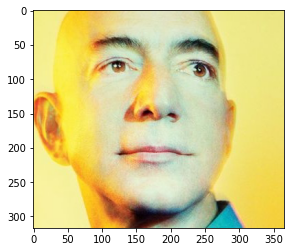

pins_dataset/train/pins_jeff bezos/jeff bezos178_2073.jpg face cannot be detected


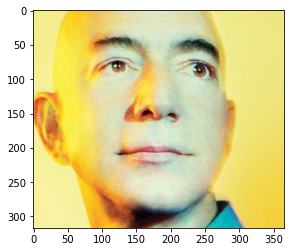

In [ ]:
def extract_face(filename, required_size=(160,160)):
    detector = MTCNN()
    image = Image.open(filename)
    image = image.convert('RGB')
    pixels = asarray(image)
    faces = detector.detect_faces(pixels)

    face_array = None
    if len(faces) > 0:
      initialX, initialY, initialWidth, initialHeight = faces[0]['box']
      used_index = 0
      highestWidth = initialX
      highestHeight = initialY
      index = 0
      for face in faces:
      #With Assumption that we're going to close up the targetted person
          x, y, width, height = face['box']
          if width > highestWidth or height > highestHeight :
              used_index = index
              break

          index = index + 1
          
      x1, y1, width, height = faces[used_index]['box']    
      x1, y1 = abs(x1), abs(y1)
      x2, y2 = x1 + width, y1 + height
      face_boundary = pixels[y1:y2, x1:x2]
      face_image = Image.fromarray(face_boundary)
      face_image = face_image.resize(required_size)
      face_array = asarray(face_image)
      # print(used_index)
      return face_array
    else:
      print(f'{filename} face cannot be detected')
      plt.imshow(image)
      plt.show()
    return face_array

def load_faces(directory):
    faces = []
    for filename in os.listdir(directory):
      path = os.path.join(directory, filename)
      face = extract_face(path)
      if face is not None:
        faces.append(face)
    return faces

def load_dataset(directory):
    x, y = [], []
    counter = 1
    for subdir in os.listdir(directory):
      path = os.path.join(directory, subdir + '/') # e.g: train/ben_afflect/
      print(f'processing {path} ({counter} out of {len(os.listdir(directory))})...')
      faces = load_faces(path)
      labels = [subdir for i in range(len(faces))] # assign label to each face
      x.extend(faces)
      y.extend(labels)
      print('>loaded %d examples for class: %s' % (len(faces), subdir))
      counter += 1
    return asarray(x), asarray(y)

train_dir = os.path.join(collection_dir, 'train')
train_X, train_y = load_dataset(train_dir)
print(train_X.shape, train_y.shape)
val_dir = os.path.join(collection_dir, 'val')
val_X, val_y = load_dataset(val_dir)
print(val_X.shape, val_y.shape)
np.savez_compressed('faces-only-dataset.npz', train_X, train_y, val_X, val_y)

#Create Embedding for Each Face
From the face generated earlier, we create an embedding of the face using FaceNet

In [ ]:
import time

data = np.load('faces-only-dataset.npz')
train_X, train_y = data['arr_0'], data['arr_1']
test_X, test_y = data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (train_X.shape[0], test_X.shape[0]))
print('Loaded: ', train_X.shape, train_y.shape, test_X.shape, test_y.shape)

model = load_model('facenet_keras.h5')
print('Loaded Model')

def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype('float32')
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean)/std
    samples = np.expand_dims(face_pixels, axis=0)
    y_hat = model.predict(samples) # get the embedding
    return y_hat

start = time.time()
new_train_X = list()
for face_pixels in train_X:
	embedding = get_embedding(model, face_pixels)
	new_train_X.extend(embedding)
 
new_train_X = asarray(new_train_X)
print(new_train_X.shape)

new_test_X = list()
for face_pixels in test_X:
	embedding = get_embedding(model, face_pixels)
	new_test_X.extend(embedding)
new_test_X = asarray(new_test_X)

print(new_test_X.shape)
end = time.time()
print(f'End processing for {end - start} seconds')

np.savez_compressed('faces-embeddings.npz', new_train_X, train_y, new_test_X, test_y)

## Performing Faces Classification

From the embedding, we perform the face classification using SVM model and the embedding as the feature. The target is the face classes (whom the face is)

In [ ]:
data = np.load('faces-embeddings.npz')
train_X, train_y = data['arr_0'], data['arr_1']
test_X, test_y = data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (train_X.shape[0], test_X.shape[0]))

from sklearn.preprocessing import Normalizer, LabelEncoder

in_encoder = Normalizer(norm='l2')
train_X = in_encoder.transform(train_X)
test_X = in_encoder.transform(test_X)

out_encoder = LabelEncoder()
out_encoder.fit(train_y)
train_y = out_encoder.transform(train_y)
test_y = out_encoder.transform(test_y)

from sklearn.svm import SVC
model_svm = SVC(kernel='linear', probability=True)
model_svm.fit(train_X, train_y)

from sklearn.metrics import accuracy_score

# predict
yhat_train = model_svm.predict(train_X)
yhat_test = model_svm.predict(test_X)

# score
score_train = accuracy_score(train_y, yhat_train)
score_test = accuracy_score(test_y, yhat_test)

print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

In [ ]:
def top_10_prediction(prob, labels):
  label_prob = {}
  counter = 0
  for label in labels:
      label_prob[label.replace(' ', '_')] = prob[counter]*100
      counter += 1

  s = sorted(label_prob.items(), key=lambda x: x[1], reverse=True)[:10]
  for k, v in s:
      print(k.replace('pins_', '').replace('_', ' '), f'{v:.2f}')

In [ ]:
# test model on a random example from the test dataset
import random
data = np.load('faces-only-dataset.npz')
test_X_faces = data['arr_2']

selection = random.choice([i for i in range(test_X.shape[0])])
random_face_pixels = test_X_faces[selection]
random_face_emb = test_X[selection]
random_face_class = test_y[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
# prediction for the face
samples = np.expand_dims(random_face_emb, axis=0)
yhat_class = model_svm.predict(samples)
yhat_prob = model_svm.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
# plot for fun
plt.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()
top_10_prediction(yhat_prob[0], out_encoder.classes_)

## Export the Model

Export the model to be used in other environment

In [ ]:
from sklearn.externals import joblib 
ten
np.save('face_classes.npy', out_encoder.classes_)

In [ ]:
def setup():
  # Download pre-trained FaceNet model, pre-trained SVM, and photo labels
  import os

  if not os.path.exists('facenet_keras.h5'):
      !wget https://github.com/D2KLab/Face-Celebrity-Recognition/raw/master/model/facenet_keras.h5
  if not os.path.exists('face_classes.npy'):      
      !wget https://ibam.imfast.io/face_classes.npy
  if not os.path.exists('svm_model.pkl'):      
      !wget https://ibam.imfast.io/svm_model.pkl

  # install mtcnn
  try:
      import mtcnn
  except ModuleNotFoundError:
      !pip install mtcnn

def get_pre_trained():
    from sklearn.preprocessing import LabelEncoder

    encoder = LabelEncoder()
    encoder.classes_ = np.load('face_classes.npy')
    model_svm = joblib.load('svm_model.pkl')
    model_facenet = load_model('facenet_keras.h5')
    return model_facenet, model_svm, encoder

def predict_face(model_facenet, model_svm, out_encoder):
    from google.colab import files

    uploaded = files.upload()
    file_name = list(uploaded.keys())[0]
    face_pixels = extract_face(file_name)
    embedding = get_embedding(model_facenet, face_pixels)
  
    predicted_class = model_svm.predict(embedding)
    object_classes = out_encoder.classes_
    # print('original', object_classes)
    # print('object type:', type(object_classes))
    # display(f'Classes: {object_classes}')
    test_array = object_classes.tolist()
    # print('updated', test_array)
    # print('predicted', predicted_class[0])
    predicted_name = object_classes[predicted_class]
    test_name = test_array[predicted_class[0]]
    # print('name', test_name)
    probabilities = model_svm.predict_proba(embedding)[0]
    predicted_probability = probabilities[predicted_class] * 100
    print(f'Predicted {predicted_name} with probabilty {predicted_probability}%')
    print('Top 10 predicted faces:')
    print(top_10_prediction(probabilities, out_encoder.classes_))

In [ ]:
setup()
model_facenet, model_svm, encoder = get_pre_trained()
predict_face(model_facenet, model_svm, encoder)